___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://miro.medium.com/max/1400/1*vkQ0hXDaQv57sALXAJquxA.jpeg" width="500px" height="100px" />


# <font color= #8A0829> Convolutional Neural Network (CNN).</font>

<Strong> Objetivos </Strong>
- Desarrollar modelos CNN para la predicción de series temporales univariantes.
- Desarrollar modelos CNN para la predicción de series temporales multivariables.
- Desarrollar modelos CNN para la previsión de series temporales en varios pasos.
> Referencias: 
    > - http://introtodeeplearning.com/2022/slides/6S191_MIT_DeepLearning_L3.pdf
    > - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
    > - Capítulo 8 de [Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
___

# 1. Modelos CNN univariados

Como hemos visto en los modelos previos, para poder implementar modelos CNN necesitamos realizar dos procedimientos:
1. Preparación de datos
2. Modelado con CNN.

## 1.1 Preparación de datos
Antes de modelar una serie univariante, hay que prepararla. El modelo CNN aprenderá una función que mapea una secuencia de observaciones pasadas como entrada a una observación de salida. Para ello, la secuencia de observaciones debe transformarse en múltiples ejemplos a partir de los cuales el modelo pueda aprender. Consideremos una secuencia univariante dada:
```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
```
Podemos dividir la secuencia en múltiples patrones de entrada/salida llamados muestras, donde tres pasos temporales se usan como entrada y un paso temporal se usa como salida para la predicción de un paso que se está aprendiendo.
```
X,           y
10, 20, 30, 40
20, 30, 40, 50
30, 40, 50, 60
...
```
Para realizar este procedimiento vamos a utilizar la función que desarrollamos en clases pasadas:

In [1]:
# Paqueterías necesarias
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

2024-02-29 19:05:13.818927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# Definir la secuencia de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Elegir un número de pasos de tiempo
n_steps = 3
# Número de características de mis datos
n_features = 1
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)

print('X', X, 'y', y, sep='\n')

X
[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]]
y
[40 50 60 70 80 90]


## 1.2 Modelado con CNN

Una CNN unidimensional es un modelo de CNN que tiene una capa oculta convolucional que opera sobre una secuencia 1D. En algunos casos, como en el de secuencias de entrada muy largas, puede haber una segunda capa convolucional y, a continuación, una capa de agrupación cuya función es reducir la salida de la capa convolucional a los elementos más destacados. Las capas convolucionales y de agrupación van seguidas de una capa densa totalmente conectada que interpreta las características extraídas por la parte convolucional del modelo. Entre las capas convolucionales y la capa densa se utiliza una capa de aplanamiento para reducir los mapas de características a un único vector unidimensional. Podemos definir un modelo CNN 1D para la predicción de series temporales univariantes de la siguiente manera.

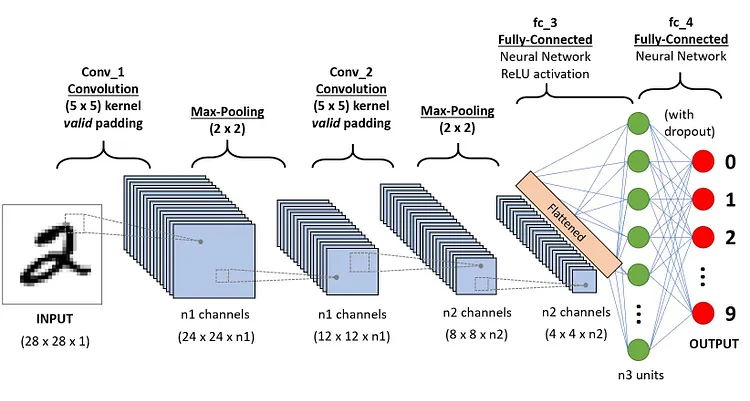

In [4]:
# Definimos nuestro modelo
model_1 = Sequential()
model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D())
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
______________________________________________________

2024-02-29 19:11:35.201840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Antes de entrenar nuestro modelo debemos redimensionar nuestros datos de entrada

In [9]:
# reshape de [samples, timesteps] a [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

Con estos datos estamos listo para entrenar nuestro modelo

In [5]:
# Ajustamos el modelo anterior
history_1 = model_1.fit(X, y, epochs=1000, verbose=False)

<Axes: >

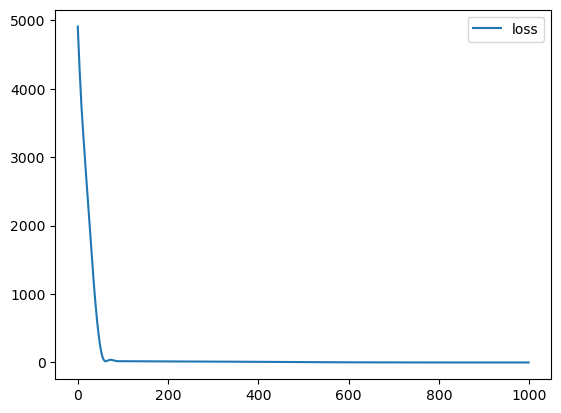

In [6]:
pd.DataFrame(history_1.history).plot()

In [7]:
# Probamos nuestro modelo 
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_1.predict(x_input, verbose=0)
yhat

array([[101.50838]], dtype=float32)

# 2. Modelos CNN multivariados

Por datos de series temporales multivariantes se entienden los datos en los que hay más de una observación para cada cada paso temporal. Hay dos modelos principales que podemos necesitar con datos de series temporales multivariantes; ellos son:
1. Series de entrada múltiples.
2. Múltiples Series Paralelas.

## 2.1 Series de entradas múltiples

Las series temporales de entrada son paralelas porque cada serie tiene observaciones en los mismos pasos temporales

In [8]:
# Definir secuencias de entrada
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
output_seq = in_seq1 + in_seq2

in_seq1.shape, output_seq.shape

((9,), (9,))

In [9]:
# Vamos a poner toda esta información en forma matricial 2D
# Para ello tenemos que definir el shape de cada secuencia
in_seq1 = in_seq1.reshape(in_seq1.shape[0], 1)
in_seq2 = in_seq2.reshape(in_seq2.shape[0], 1)
output_seq = output_seq.reshape(output_seq.shape[0], 1)

in_seq1.shape, output_seq.shape

((9, 1), (9, 1))

In [10]:
# Concatenar horizontalmente nuestra data
dataset = np.hstack([in_seq1, in_seq2, output_seq])
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [11]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence(sequence: np.ndarray, n_steps: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
n_steps = 3
X, y = split_multivariate_sequence(dataset, n_steps)

n_features = X.shape[2]

X.shape, y.shape

((7, 3, 2), (7,))

Esta es la estructura tridimensional exacta que espera una CNN 1D como entrada. Los datos están listos para ser utilizados sin más modificaciones. 

### Modelo CNN

In [13]:
# Definimos nuestro modelo
model_2 = Sequential()
model_2.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_2.add(MaxPooling1D())
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
____________________________________________________

In [14]:
# Ajustamos el modelo anterior
history_2 = model_2.fit(X, y, epochs=1000, verbose=False)

<Axes: >

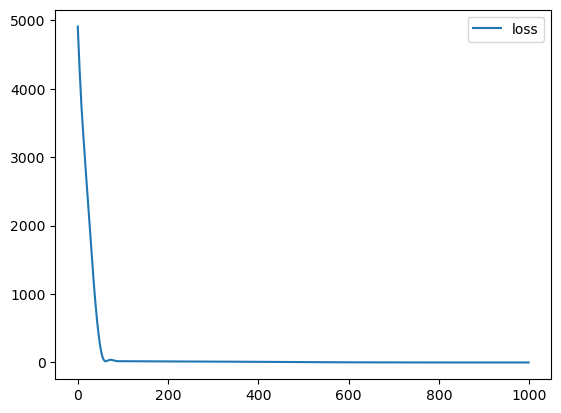

In [15]:
pd.DataFrame(history_1.history).plot()

In [16]:
# Probamos nuestro modelo 
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_2.predict(x_input, verbose=0)
yhat

array([[207.50362]], dtype=float32)

## Modelo CNN con múltiples encabezamientos

Existe otra forma más elaborada de modelizar el problema. Cada serie de entrada puede ser tratada por una CNN distinta y la salida de cada uno de estos submodelos puede combinarse antes de hacer una predicción para la secuencia de salida. Podemos referirnos a esto como un modelo CNN de múltiples submodelos. Puede ofrecer más flexibilidad o un mejor rendimiento en función de las características específicas del problema que se esté modelando. Por ejemplo, permite configurar cada submodelo de forma diferente para cada entrada como el número de filtros y el tamaño del kernel. Este tipo de modelo se puede definir en Keras utilizando la API funcional de Keras. En primer lugar, podemos definir el primer modelo de entrada como una CNN 1D con una capa de entrada que espera vectores con n pasos y 1 característica

In [18]:
# Paqueterías faltantes
from keras.models import Model
from keras.layers.merging import concatenate
from keras.utils import plot_model
from keras.layers import Input

In [19]:
n_features = 1
n_steps = 3

In [20]:
# Primer modelo de entrada
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(64, 2, activation='relu')(visible1)
cnn1 = MaxPooling1D()(cnn1)
cnn1 = Flatten()(cnn1)

In [21]:
# Segundo modelo de entrada
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(64, 2, activation='relu')(visible2)
cnn2 = MaxPooling1D()(cnn2)
cnn2 = Flatten()(cnn2)

Ahora que se han definido los dos submodelos de entrada, podemos fusionar la salida de cada modelo en un vector largo que puede interpretarse antes de hacer una predicción para la secuencia de salida.

In [22]:
# merge modelos de entrada
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)

In [23]:
# Conectar entradas y salida del modelo
model_3 = Model(inputs=[visible1, visible2], outputs=output)

model_3.compile(optimizer='adam', loss='mse')

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2, 64)        192         ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2, 64)        192         ['input_2[0][0]']                
                                                                                              

Para poder visualizar el modelo generado como un grafo es necesario instalar las siguientes paqueterías:
1. `conda install -c anaconda pydot`
2. graphviz ver instrucciones de instalación en https://graphviz.gitlab.io/download/

In [24]:
%conda install -c anaconda pydot 

Retrieving notices: ...working... done
Channels:
 - anaconda
 - defaults
 - conda-forge
 - plotly
Platform: osx-64
Solving environment: | ^C

Note: you may need to restart the kernel to use updated packages.


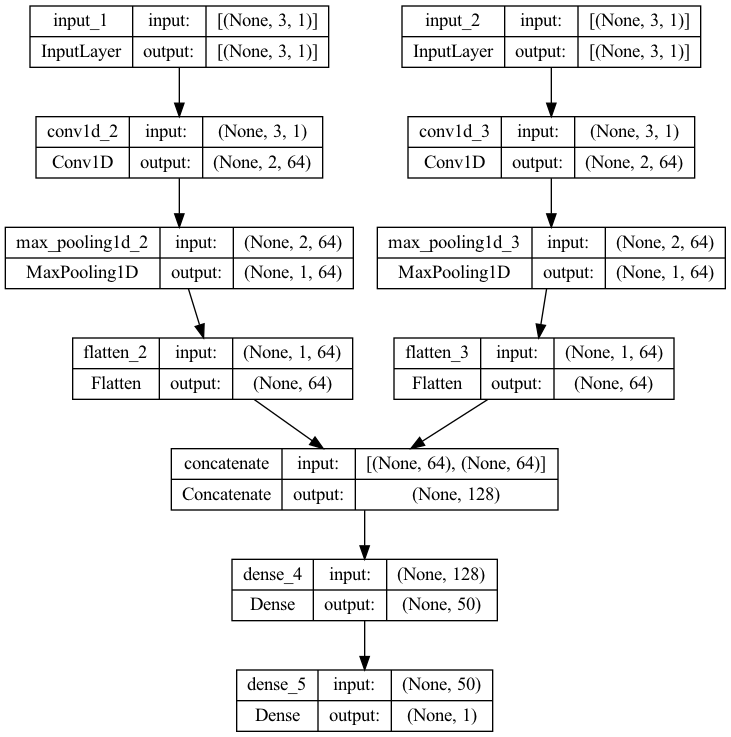

In [25]:
plot_model(model_3, to_file='model.png', show_shapes=True, show_layer_names=True)

Con este modelo debemos ingresar cada serie de entrada por separado, es decir que para nuestros datos que están con tamaño de `[7, 3, 2]` lo particionaremos para tener dos arreglos de `[7, 3, 1]`.

In [26]:
# Una serie de tiempo por submodelo
n_features = 1

# Separar datos de entrada
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)

In [27]:
# Con estos datos podemos ajustar el modelo
history_3 = model_3.fit([X1, X2], y, epochs=1000, verbose=0)

<Axes: >

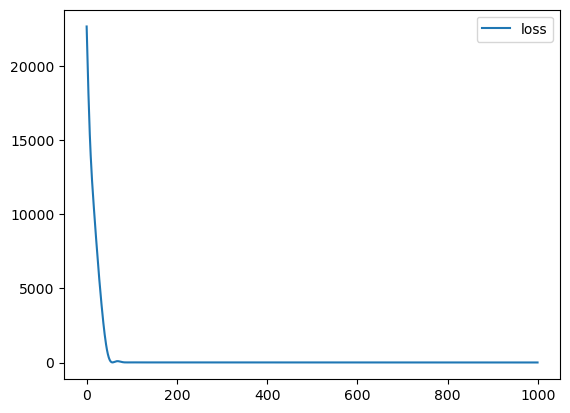

In [28]:
pd.DataFrame(history_3.history).plot()

In [29]:
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps, n_features))
x2 = x_input[:, 1].reshape((1, n_steps, n_features))
yhat = model_3.predict([x1, x2], verbose=0)
print(yhat)

[[207.49797]]


## 2.2 Múltiples series paralelas (multivariable forecasting)

Un problema de series temporales alternativo es el caso en el que hay múltiples series temporales paralelas y se debe realizar una predecicción para cada una de ellas. Por ejemplo, dados los datos de la sección anterior:
```
[[ 10 15 25]
[ 20 25 45]
[ 30 35 65]
[ 40 45 85]
[ 50 55 105]
[ 60 65 125]
[ 70 75 145]
[ 80 85 165]
[ 90 95 185]]
```
Es posible que queramos predecir el valor de cada una de las tres series temporales para el siguiente paso temporal. Esto podría denominarse predicción multivariante. Una vez más, los datos deben dividirse en muestras de entrada/salida para poder entrenar un modelo. La primera muestra de este conjunto de datos sería:

**Entrada**
```
10, 15, 25
20, 25, 45
30, 35, 65
```
**Salida**
```
40, 45, 85
```

Para este comportamiento debemos de modificar un poco la función `split_multivariate_sequence()` de la siguiente forma

In [30]:
# dividir una secuencia multivariada en muestras para predicción múltiple
def split_multiple_forecasting_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [31]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [32]:
n_steps = 3
X_m, y_m = split_multiple_forecasting_sequence(dataset, n_steps=3)

In [33]:
X_m.shape

(6, 3, 3)

In [34]:
print(X_m[0], y_m[0], sep='\n')

[[10 15 25]
 [20 25 45]
 [30 35 65]]
[40 45 85]


Con esto ya estamos listos para ajustar nuestro 1D modelo CNN sobre estos datos.

In [36]:
n_features = X_m.shape[2]

# define model_4
model_4 = Sequential()
model_4.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_4.add(MaxPooling1D())
model_4.add(Flatten())
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(n_features))
model_4.compile(optimizer='adam', loss='mse')

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 64)             448       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                3250      
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
____________________________________________________

In [37]:
# Ajustar el modelo
history_4 = model_4.fit(X_m, y_m, epochs=1000, verbose=0)

<Axes: >

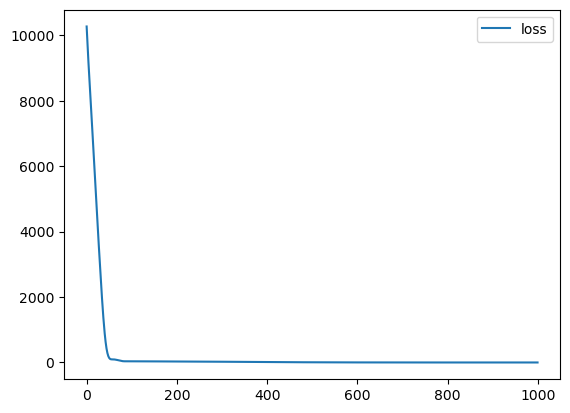

In [38]:
pd.DataFrame(history_4.history).plot()

In [39]:
# Probar el modelo
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_4.predict(x_input, verbose=0)
print(yhat)

[[101.88599 106.37384 207.88907]]


### Multi-output CNN Model

Para este modelo cada serie de salida puede ser tratada por un modelo CNN de salida independiente. Este modelo, puede ofrecer más flexibilidad o mejor rendimiento dependiendo de las características específicas del problema que se esté modelando. En primer lugar, podemos definir el primer modelo de entrada como un modelo CNN 1D.

In [40]:
# Definimos el modelo
n_features = X_m.shape[2]

visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(64, 2, activation='relu')(visible)
cnn = MaxPooling1D()(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)

Podemos definir una capa de salida para cada una de las tres series que queremos predecir, donde cada submodelo de salida predecirá un único paso temporal.

In [41]:
# Definimos salida 1
output1 = Dense(1)(cnn)
# Definimos salida 2
output2 = Dense(1)(cnn)
# Definimos salida 3
output3 = Dense(1)(cnn)

A continuación, podemos unir las capas de entrada y salida en un único modelo.

In [42]:
# Ponemos todo junto
model_5 = Model(inputs=visible, outputs=[output1, output2, output3])
model_5.compile(optimizer='adam', loss='mse')

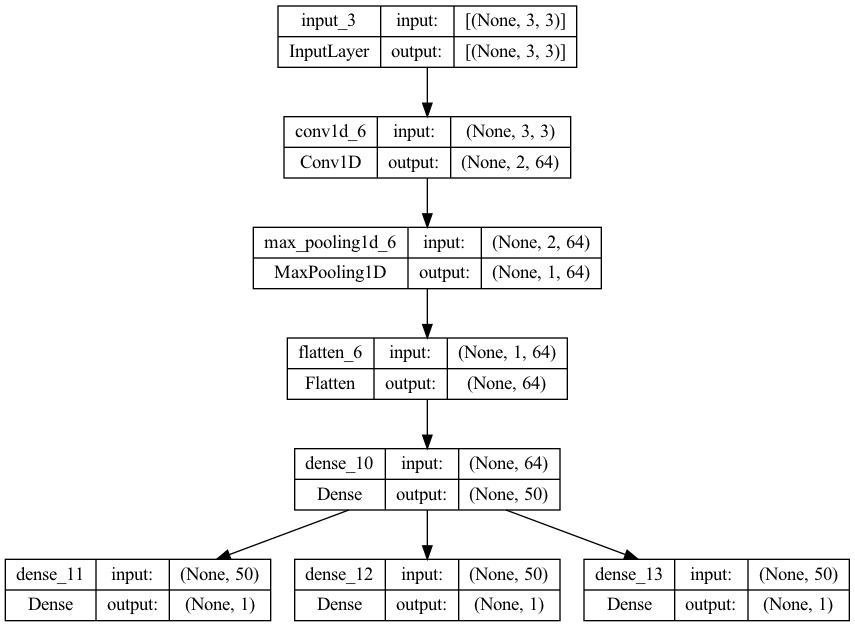

In [43]:
plot_model(model_5, show_shapes=True, show_layer_names=True)

Al entrenar el modelo, se necesitarán tres matrices de salida separadas por muestra. Podemos conseguirlo convirtiendo los datos de entrenamiento de salida que tienen la forma `[7, 3]` en tres matrices con la forma `[7, 1]`.

In [44]:
y_m[:, 0].shape

(6,)

In [45]:
# Separar salidas
y1 = y_m[:, 0].reshape((y_m.shape[0], 1))
y2 = y_m[:, 1].reshape((y_m.shape[0], 1))
y3 = y_m[:, 2].reshape((y_m.shape[0], 1))

In [46]:
# Ajustar el modelo
history_5 = model_5.fit(X_m, [y1,y2,y3], epochs=750, verbose=0)

<Axes: >

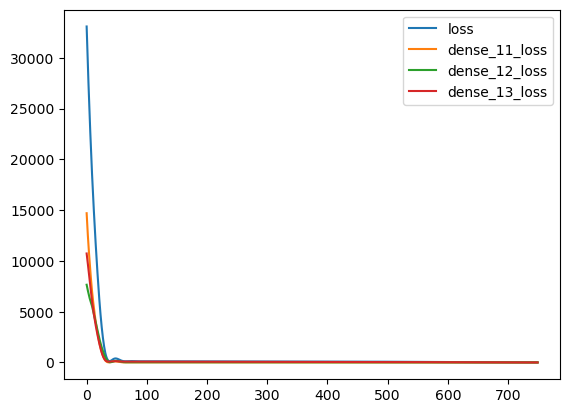

In [47]:
pd.DataFrame(history_5.history).plot()

In [48]:
# Probar nuestro modelo
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_5.predict(x_input, verbose=0)
print(yhat)

[array([[99.94549]], dtype=float32), array([[108.699135]], dtype=float32), array([[207.88931]], dtype=float32)]


# 3. Modelos CNN de pasos múltiples

En la práctica, hay poca diferencia con el modelo CNN 1D a la hora de predecir un vector de salida que representa diferentes variables de salida (como en el ejemplo anterior), o un vector de salida que representa múltiples pasos temporales de una variable. No obstante, existen diferencias sutiles e importantes en la forma de preparar los datos de entrenamiento. En esta sección, demostraremos el caso del desarrollo de un modelo de predicción de múltiples pasos utilizando un modelo vectorial. Antes de examinar los detalles del modelo, veamos cómo se preparan los datos para la predicción en varios pasos.

## 3.1 Serie temporal univariada
Ejemplo,
```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
```
Pudiéramos usar tres pasos de la entrada para predecir los siguientes dos pasos. Para el ejemplo anterior la primera muestra de la entrada sería

**Entrada**
```
[10, 20, 30]
```
**Salida**
```
[40, 50]
```

In [49]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence_m_step(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [50]:
# Probemos la función creada
# Definir secuencia de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2
# Particionar mis datos
X, y = split_univariate_sequence_m_step(raw_seq, n_steps_in, n_steps_out)
# Resumir los datos
[print(X[i], y[i]) for i in range(len(X))];

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [51]:
X.shape, y.shape

((5, 3), (5, 2))

In [52]:
# Debemos tranformar nuestro datos de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(5, 3, 1)

In [53]:
# Crear nuestro modelo
model_6 = Sequential()
model_6.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_6.add(MaxPooling1D())
model_6.add(Flatten())
model_6.add(Dense(50, activation='relu'))
model_6.add(Dense(n_steps_out))
model_6.compile(optimizer='adam', loss='mse')

model_6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 50)                3250      
                                                                 
 dense_15 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,544
Trainable params: 3,544
Non-trainable params: 0
____________________________________________________

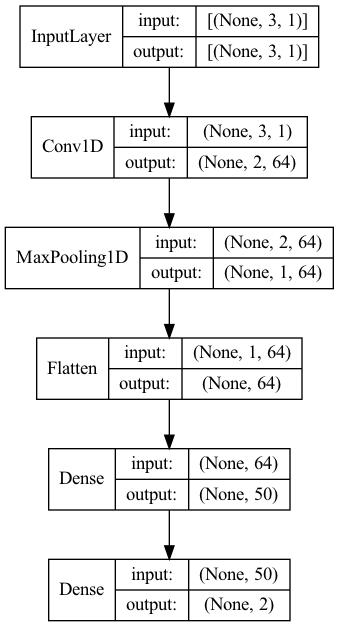

In [54]:
plot_model(model_6, show_layer_names=False, show_shapes=True,)

In [55]:
# fit model
history_6 = model_6.fit(X, y, epochs=1000, verbose=0)

<Axes: >

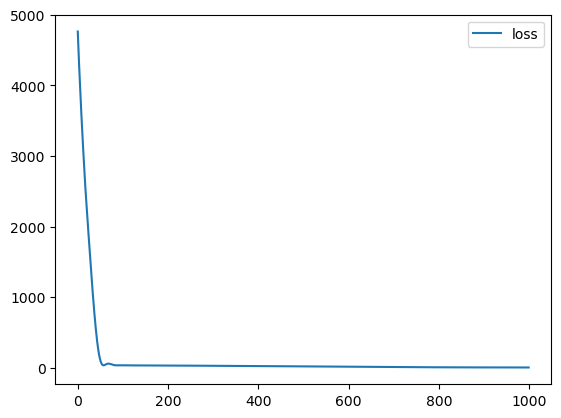

In [56]:
pd.DataFrame(history_6.history).plot()

In [58]:
# Predecir con nuestro modelo
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model_6.predict(x_input, verbose=0)
print('Predicción', yhat)

Predicción [[102.63619 116.16718]]


## 3.2 Serie temporal multivariada

El procedimiento que debemos de seguir para predecir múltiples pasos en una serie temporal multivariable es similar a los procedimientos dichos con las siguientes variaciones. Suponga que tiene una serie de tiempo multivariada con dos variables externas y una salida con la siguiente estructura:

**Datos**
```
[[ 10 15 25]
[ 20 25 45]
[ 30 35 65]
[ 40 45 85]
[ 50 55 105]
[ 60 65 125]
[ 70 75 145]
[ 80 85 165]
[ 90 95 185]]
```
**Entrada**
```
10, 15
20, 25
30, 35
```
**Salida**
```
65
85
```

Para construir estas secuencias de entradas y salidas, debemos de modificar la función `split_multivariate_sequence` para que considere este escenario


In [59]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [60]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [61]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step(dataset, n_steps_in, n_steps_out)

In [62]:
# Mostrar los resultados
print(X.shape, y.shape)
for i in range(len(X)):
    print(X[i], y[i])

(6, 3, 2) (6, 2)
[[10 15]
 [20 25]
 [30 35]] [65 85]
[[20 25]
 [30 35]
 [40 45]] [ 85 105]
[[30 35]
 [40 45]
 [50 55]] [105 125]
[[40 45]
 [50 55]
 [60 65]] [125 145]
[[50 55]
 [60 65]
 [70 75]] [145 165]
[[60 65]
 [70 75]
 [80 85]] [165 185]


Con los datos preprocesados podemos construir nuestro modelo de 1D CNN para predicciones en múltiples pasos.

In [63]:
n_features = X.shape[2]

# Definir el modelo 
model_7 = Sequential()
model_7.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_7.add(MaxPooling1D())
model_7.add(Flatten())
model_7.add(Dense(50, activation='relu'))
model_7.add(Dense(n_steps_out))
model_7.compile(optimizer='adam', loss='mse')
# fit model_7
model_7.fit(X, y, epochs=2000, verbose=0)

model_7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                3250      
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,672
Trainable params: 3,672
Non-trainable params: 0
____________________________________________________

In [64]:
# Predecir con nuestro modelo
x_input = np.array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model_7.predict(x_input, verbose=0)
print(yhat)

[[185.38112 207.20816]]


## 3.3 Serie temporal multivariada predicción múltiple de cada entrada

En este caso, se pretende poder estimar cada feature de entrada de una serie de tiempo en múltiples pasos de tiempo. Por ejemplo, considere la siguiente serie de tiempo multivariada

**Datos**
``` 
[[ 10 15 25]
[ 20 25 45]
[ 30 35 65]
[ 40 45 85]
[ 50 55 105]
[ 60 65 125]
[ 70 75 145]
[ 80 85 165]
[ 90 95 185]]
```
**Entrada**
```
10, 15, 25
20, 25, 45
30, 35, 65
```
**Salida**
```
40, 45, 85
50, 55, 105
```
Para poder tener nuestros datos con la forma deseada necesitamos modificar un poco la función `split_multivariate_sequence_m_step` de la siguiente manera:

In [65]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step_parallel(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [67]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step_parallel(dataset, n_steps_in, n_steps_out)

In [68]:
# Mostrar los resultados
print(X.shape, y.shape)
for i in range(len(X)):
    print(X[i], y[i])

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [[ 80  85 165]
 [ 90  95 185]]


Antes de poder pasar a la construcción de nuestro modelo 1D CNN, debemos de usar un vector de salida. Como tal, debemos aplanar la estructura tridimensional de la porción de salida de cada muestra para entrenar el modelo. Esto significa que, en lugar de predecir dos pasos para cada serie, el modelo se entrena y se espera que prediga directamente un vector de seis números.

In [69]:
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
y.shape

(5, 6)

In [70]:
n_features = X.shape[2]

# Definimos nuestro modelo
model_8 = Sequential()
model_8.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_8.add(MaxPooling1D())
model_8.add(Flatten())
model_8.add(Dense(50, activation='relu'))
model_8.add(Dense(n_output))
model_8.compile(optimizer='adam', loss='mse')

# fit model_8
history_8 = model_8.fit(X, y, epochs=1000, verbose=0)

<Axes: >

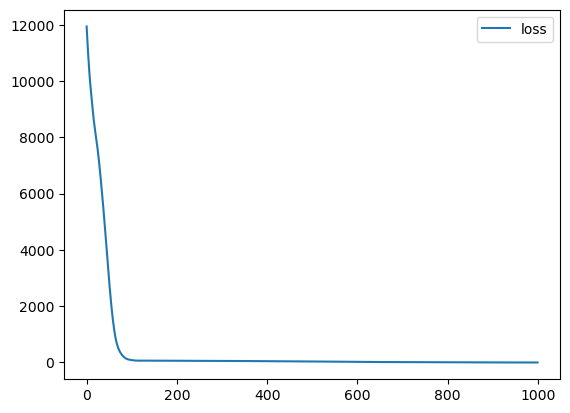

In [71]:
pd.DataFrame(history_8.history).plot()

In [72]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [75]:
# Probar nuestro modelo
x_input = np.array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model_8.predict(x_input, verbose=0)
print(yhat)

[[ 90.96651   95.60945  189.60893  102.03622  109.037605 212.96814 ]]


In [80]:
yhat.shape

(1, 6)

In [100]:
[yhat[i].reshape(n_steps_out, n_features) for i in range(yhat.shape[0])]

[array([[ 92.49296,  98.10544, 187.5263 ],
        [102.66568, 108.01113, 213.7502 ]], dtype=float32)]

# <font color= red>  Tarea  </font>

Implementar todas las técnicas vistas en esta clase al siguiente dataset para predecir el precio de las viviendas:

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>